# **Prerequisites**
Before we start the coding part, make sure that you have set up your Python 3 environment and required packages. If you don’t have an environment set up yet, you can follow the steps in this [tutorial](https://www.relataly.com/anaconda-python-environment-machine-learning/1663/) to set up the Anaconda environment or you can use Google Colab Tools. 

# **Step #1 Import and install required Library/Packaged**

In [ ]:
# Package/Library for stemming Bahasa
!pip install Sastrawi
# Package/Library for use model transformers
!pip install transformers==4.10.2

In [1]:
# NLP
import nltk
nltk.download('punkt')
nltk.download('stopwords')
import string 
import re
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from wordcloud import WordCloud, STOPWORDS

# Data Manipulation
import os
import csv
import pandas as pd
import numpy as np
import itertools
import statistics
import time
import datetime

# Ignore Warning Error
import warnings
warnings.filterwarnings("ignore")

# Model IndoBERT
import random
import transformers
import torch
import torch.nn.functional as F
from torch import optim
from tqdm import tqdm
from transformers import BertForSequenceClassification, BertConfig, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import Dataset, DataLoader,TensorDataset, random_split, RandomSampler, SequentialSampler
from pylab import rcParams

# Splitting 
from sklearn.model_selection import train_test_split

# Evaluation
from sklearn.metrics import classification_report, confusion_matrix
from collections import defaultdict
from textwrap import wrap

# Vizualization
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 6, 4

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


# **Step #2 Load Dataset**

In [ ]:
# Read dataset
df_yt_comment = pd.read_csv('ytb_comments_multi.csv')
df_yt_comment

# **Step #3 Preprocessing Text**

**LOWERCASING**

The **lowercasing** is an important text preprocessing step in which we convert the text into the same casing, preferably all in lowercase so that the words Youtube, YOutube, and YOUTUBE can be treated in the same way as “youtube”. It is helpful in text featurization techniques like term frequency, TFIDF since it prevents duplication of same words having different casing.


In [ ]:
# Do preprocessing casefolding = change capital letters to lowercase 
df_yt_comment['text'] = df_yt_comment['text'].str.lower()

print('Case Folding Result : \n')
print(df_yt_comment['text'].head(50))

**CLEANSING AND TOKENIZING**


**Cleansing** is a process which removes unimportant texts such as (@, #, links), numeric characters, non-alphabet characters, punctuation marks, empty characters, emoticon characters, repetitive characters, this is done so that the training process becomes more efficient and simple.


**Tokenizing** is a process which converts a text in the form of a sentence into a word fragment.
<br> 

**For example : "pakai behel ngilu selama 2 minggu"**
<br>

**After tokenizing : "pakai", "behel", "ngilu", "selama", "minggu"**

In [ ]:
# Remove special text
def remove_text_special(text):
    # Remove space
    text = text.replace('\\t'," ").replace('\\n'," ").replace('\\u'," ").replace('\\',"")
    # Remove mention, tag, link, and hastag
    text = ' '.join(re.sub("([@#][A-Za-z0-9]+)|(\w+:\/\/\S+)"," ", text).split())
    # Remove non-ascii characters from the string
    text = re.sub(r'[^\x00-\x7f]',r'', text)
    # Remove url uncomplete
    return text.replace("http://", " ").replace("https://", " ")

df_yt_comment['text'] = df_yt_comment['text'].apply(remove_text_special)

# Remove number
def remove_number(text):
    return  re.sub(r"\d+", "", text)

df_yt_comment['text'] = df_yt_comment['text'].apply(remove_number)

# Remove punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans("","",string.punctuation))

df_yt_comment['text'] = df_yt_comment['text'].apply(remove_punctuation)

# Remove single character
def remove_singl_char(text):
    return re.sub(r"\b[a-zA-Z]\b", "", text)

df_yt_comment['text'] = df_yt_comment['text'].apply(remove_singl_char)

# Remove duplicate words
def remove_duplicate_words(text):
    return  ''.join(ch for ch, _ in itertools.groupby(text))

df_yt_comment['text'] = df_yt_comment['text'].apply(remove_duplicate_words)

# Remove emoticon
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002500-\U00002BEF"  # chinese char
                           u"\U00002702-\U000027B0"
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           u"\U0001f926-\U0001f937"
                           u"\U00010000-\U0010ffff"
                           u"\u2640-\u2642"
                           u"\u2600-\u2B55"
                           u"\u200d"
                           u"\u23cf"
                           u"\u23e9"
                           u"\u231a"
                           u"\ufe0f"  # dingbats
                           u"\u3030"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

df_yt_comment['text'] = df_yt_comment['text'].apply(remove_emoji)

# Tokenizing
def word_tokenize_wrapper(text):
    return word_tokenize(text)

df_yt_comment['text'] = df_yt_comment['text'].apply(word_tokenize_wrapper)

print('Tokenizing Result : \n') 
print(df_yt_comment['text'].head(50))

**CONVERT SLANG WORD (NORMALIZATION)**

**Convert Slangword** is the process of converting informal words into formal words according to KBBI standards, because the data obtained from scraping results from the majority of user comments are met by the use of foreign words or words in informal language.
<br>
<table>
  <tr>
    <th>Before Normalization</th>
    <th>After Normalization</th>
  </tr>
  <tr>
    <td>Gue</td>
    <td>Saya</td>
  </tr>
  <tr>
    <td>Lo</td>
    <td>Kamu</td>
  </tr>
  <tr>
    <td>Gak</td>
    <td>Tidak</td>
  </tr>
  <tr>
    <td>Wkwk</td>
    <td>Tertawa</td>
  </tr>
  <tr>
    <td>Seneng</td>
    <td>Senang</td>
  </tr>
</table>

In [ ]:
# Read slang vocabulary dictionary
convert_slang_word = pd.read_csv("new_kamusalay.csv") 

# Create a variable in the form of a dictionary that will store the results of convert slang word function
convert_slang_word_dict = {}

for index, row in convert_slang_word.iterrows():
    if row[0] not in convert_slang_word_dict:
        convert_slang_word_dict[row[0]] = row[1] 

# Function for convert slang word
def convert_slang_word_term(document):
    return [convert_slang_word_dict[term] if term in convert_slang_word_dict else term for term in document]

df_yt_comment['text'] = df_yt_comment['text'].apply(convert_slang_word_term)

print('Convert Slangword Result : \n') 
print(df_yt_comment['text'].head(50))

**NEGATION HANDLING**

**Negation Handling** is the process of dealing with the negation of a word. Negation greatly affects the polarity of other words. Example sentences **"Saya tidak suka menggunakan behel"** the meaning of the sentence means don't like it. However, in NLP (Natural Language Processing) in the pre-processing process, in the stopwords process "Tidak" is a word that included in the words contained in the stopwords dictionary. So if the stopwords process is run, the word "Tidak" will disappear and the sentence will change to **"Saya suka menggunakan behel"**. Of course this results in errors that need to be addressed and should not be ignored. Because if this is ignored, when analyzing comments of an youtube video and there are comments from users who fall into the negative category, it is considered a positive category so that the classification prediction becomes inaccurate.
<br>

**For example : "saya", "tidak", "suka", "menggunakan", "behel"**
<br>

**After negation handling : "saya", "tidak", "tidak_suka", "menggunakan", "behel"**

Negation will combine words that are after the word that means negation marked with a separator (_), but the word that means negation remains and does not disappear. Because the word will be deleted during the stopword process, leaving only the word that is the result of handling the negation.

In [ ]:
# Function for do negation handling
def negation_handling(content):
    negation_content = []
    for i in range(len(content)):
        word = content[i]
        if content[i-1] not in ['ga', 'tidak', 'kurang', 'gak', 'enggak', 'nggak', 'tak']:
            negation_content.append(word)
        else:
            word = "%s_%s" %(content[i-1],word)
            negation_content.append(word)
    return negation_content

df_yt_comment['text'] = df_yt_comment['text'].apply(negation_handling)

print('Negation Handling Result : \n') 
print(df_yt_comment['text'].head(50))

**STEMMING**

**Stemming** is the process of changing words into basic words that are in accordance with the good and correct morphological structure of Indonesian. All word affixes such as prefixes, infixes, and suffixes are removed. Derivative words that have a prefix and a suffix (confix). In this study, to carry out Indonesian stemming, uses the library provided by Python, namely the <b>Sastrawi</b> library which applies the <b>Nazief algorithm and Adriani's Stemmer.</b>

<br>
<table>
  <tr>
    <th>Before Stemming</th>
    <th>After Stemming</th>
  </tr>
  <tr>
    <td>Mendaftar</td>
    <td>Daftar</td>
  </tr>
  <tr>
    <td>Dicurigai</td>
    <td>Curiga</td>
  </tr>
  <tr>
    <td>Berbicara</td>
    <td>Bicara</td>
  </tr>
  <tr>
    <td>Kewajiban</td>
    <td>Wajib</td>
  </tr>
  <tr>
    <td>Penyempurnaan</td>
    <td>Sempurna</td>
  </tr>
</table>

In [ ]:
# Create Stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Function for stemming
def stemmed_wrapper(term):
    return stemmer.stem(term)

term_dict = {}

for document in df_yt_comment['text']:
    for term in document:
        if term not in term_dict:
            term_dict[term] = ' '
            
print(len(term_dict))
print("------------------------")

for term in term_dict:
    term_dict[term] = stemmed_wrapper(term)
    print(term,":" ,term_dict[term])
    
print(term_dict)
print("------------------------")

# Apply stemmed term to dataframe
def get_stemmed_term(document):
    return [term_dict[term] for term in document]

df_yt_comment['text'] = df_yt_comment['text'].apply(get_stemmed_term)

print('Stemming Result : \n') 
print(df_yt_comment['text'].head(50))

**STOPWORD REMOVAL**

The last process in preprocessing is **stopwords removal**. At this stage, words that have a high frequency of occurrence are removed and their use is not too important, for example, such as connecting words “dan”, “atau”, “tapi”, “akan”  and others. Deletion of these stopwords by using the list of Indonesian stopwords derived from the <b>NLTK (Natural Language Tool Kit)</b> module.

In [ ]:
# ----------------Get stopword from NLTK stopword ---------
# Get Indonesian stopword
list_stopwords = stopwords.words('indonesian')
# ------------------ Adding stopword manually ----------
# Added words to delete
list_stopwords.extend(['yg', 'dg', 'rt', 'dgn', 'ny', 'd', 'klo', 'kalo', 'amp', 'biar', 'bikin', 'bilang',
                       'krn', 'nya', 'nih', 'sih', 'tidak', 'si', 'tau', 'tdk', 'tuh', 'utk', 'ya', 'jd', 
                       'jgn', 'sdh', 'aja', 'n', 't', 'nyg', 'hehe', 'pen', 'u', 'nan', 'loh', '&amp', 'yah', 
                       'bgt', 'hahaha', 'jg', 'ng', 'kurang', 'wkwk', 'wkwkwk', 'wkwkwkwk','pasu','dip', 'byang', 
                       'bang', 'bu', 'ku', 'banget'])

# Convert list into stopwords dictionary
list_stopwords = set(list_stopwords)
# Delete word 'baik' in stopwords dictionary list
list_stopwords.remove('baik')

# Remove stopword from token list
def stopwords_removal(words):
 return [word for word in words if word not in list_stopwords]

df_yt_comment['text'] = df_yt_comment['text'].apply(stopwords_removal)

print('Stopword Removal Result : \n') 
print(df_yt_comment['text'].head(50))

In [ ]:
# Return the data back to its original form which is not a piece of a word
def join_text_list(text):
    return ' '.join(text)
    
df_yt_comment['text_clean'] = df_yt_comment['text'].apply(join_text_list)
print(df_yt_comment['text_clean'].head(50))

In [ ]:
# Save result of preprocessing text to csv
df_yt_comment.to_csv('Youtube-Comment-Preprocessing.csv', index=False)

# **Step #4 Labeling Dataset - Lexicon Based Approach**

In lexicon-based approach for sentiment analysis, words in texts are labeled as positive, negative, or sometimes as neutral with the help of a so-called lexicon dictionary. Take the phrase <b>“Kemarin hariku berjalan begitu baik, namun hari berikutnya berjalan dengan buruk”</b>. A lexicon dictionary would label the word <b>“baik”</b> as positive; the word <b>“buruk”</b> as negative; and possibly the other words as neutral.

Once each word in the text is labeled, we can derive an overall sentiment score by summation of overall polarity scores. A popular formula to calculate the sentiment score is:

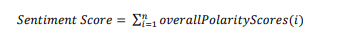

If the sentiment score is < 0, the text is classified as negative. It follows that the sentiment score is > 0 means a positive text, and a score of zero means the text is classified as neutral.

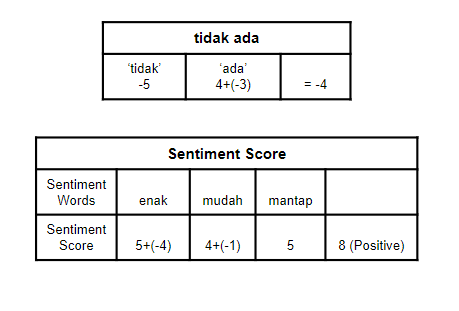

<b>Note :</b>
that in the lexicon-based approach we don’t use Machine Learning models: The overall sentiment of the text is determined on-the-fly, depending only on the dictionary that is used for labeling word dictionary. 

In [ ]:
# Load lexicon positive and negative data
lexicon_positive = dict()
with open('lexicon_positive.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        lexicon_positive[row[0]] = int(row[1])

lexicon_negative = dict()
with open('lexicon_negative_update.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        lexicon_negative[row[0]] = int(row[1])
        
# Function to determine sentiment polarity of comment        
def sentiment_analysis_lexicon_indonesia(text):
    score = 0
    for word in text:
        if (word in lexicon_positive):
            score = score + lexicon_positive[word]
    for word in text:
        if (word in lexicon_negative):
            score = score + lexicon_negative[word]
    polarity=''
    if (score > 0):
        polarity = 'positive'
    elif (score < 0):
        polarity = 'negative'
    else:
        polarity = 'neutral'
    return score, polarity

In [ ]:
# Results from determine sentiment polarity of tweets
results = df_yt_comment['text'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
df_yt_comment['polarity_score'] = results[0]
df_yt_comment['polarity'] = results[1]
print(df_yt_comment['polarity'].value_counts())

In [ ]:
# Delete column 'text' cause its not use for analysis
del df_yt_comment['text']

In [ ]:
# See result of labeling dataset to csv
df_yt_comment

In [ ]:
# Save result of labeling dataset to csv
df_yt_comment.to_csv('Youtube-Comment-Labeling.csv', index=False)

In [ ]:
# Read result of labeling dataset
df_yt_comment = pd.read_csv("Youtube-Comment-Labeling.csv")
df_yt_comment

# **Step #5 Handling Missing Values**

In [ ]:
# Checking if the dataset has a value of Null/NaN
is_NaN = df_yt_comment.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = df_yt_comment[row_has_NaN]
rows_with_NaN

In [ ]:
# Remove data that have NAN value in column text_clean
df_yt_comment.dropna(subset=['text_clean'], inplace = True)
df_yt_comment

In [ ]:
# To reset the index when data with NAN values ​​are removed so that the index numbering matches
df_yt_comment = df_yt_comment.reset_index(drop = True)
# Print the results of the dataframe that has been created
df_yt_comment

# **Step #6 Convert String To Integer Based On Column "polarity"**

In [ ]:
# Convert String To Integer Based On Column "polarity"
def to_sentiment(polarity):
    if polarity == 'negative':
      return 0
    elif polarity == 'positive':
      return 1
    else:
      return 2

df_yt_comment['sentiment'] = df_yt_comment.polarity.apply(to_sentiment)
df_yt_comment

In [ ]:
# Save result dataset to csv as Final Dataset for analysis
df_yt_comment.to_csv('Youtube-Comment-Final.csv', index=False)

# **Step #7 Exploratory Data Analysis**

In [2]:
# Read result of final dataset
df_yt_comment = pd.read_csv("Youtube-Comment-Final.csv")
df_yt_comment

,author,time,urls,votes,text_clean,polarity_score,polarity,sentiment
0,devi Shelvia,38 menit yang lalu,https://youtu.be/a7c8BArQs-s,0,pakai behel gigi rapi tidak pada senyum tertaw...,5,positive,1
1,Azmi Zahra Dzakiyyah,8 hari yang lalu,https://youtu.be/a7c8BArQs-s,0,warna karet behel bagus kakak,2,positive,1
2,Diana Moreira,11 hari yang lalu,https://youtu.be/a7c8BArQs-s,0,habis lepas behel k pakai retainer gigi tidak ...,-4,negative,0
3,ONE milion,3 minggu yang lalu,https://youtu.be/a7c8BArQs-s,0,gigi masuk rapi tipe open bite gigi tidak sali...,11,positive,1
4,Muhammad Farhan Afriansyah,3 minggu yang lalu,https://youtu.be/a7c8BArQs-s,0,ngerapihin gigi pergi kah gigi langsung padang,1,positive,1
...,...,...,...,...,...,...,...,...
9701,IndriTikameiy,2 tahun yang lalu,https://youtu.be/wuAjzLtvWrE,0,mb kemarin pergi gigi rumah sakit daerah pakai...,-10,negative,0
9702,IndriTikameiy,2 tahun yang lalu,https://youtu.be/wuAjzLtvWrE,0,gigi juta kak gigi beli motor kak,1,positive,1
9703,nonamarten,2 tahun yang lalu,https://youtu.be/wuAjzLtvWrE,1,sat jakbar nama liem clinic cari klinik saran ...,1,positive,1
9704,-Youtuber Gagal-,2 tahun yang lalu,https://youtu.be/wuAjzLtvWrE,0,sp ort maksud kak pasang kawat gigi ahli gigi ...,8,positive,1


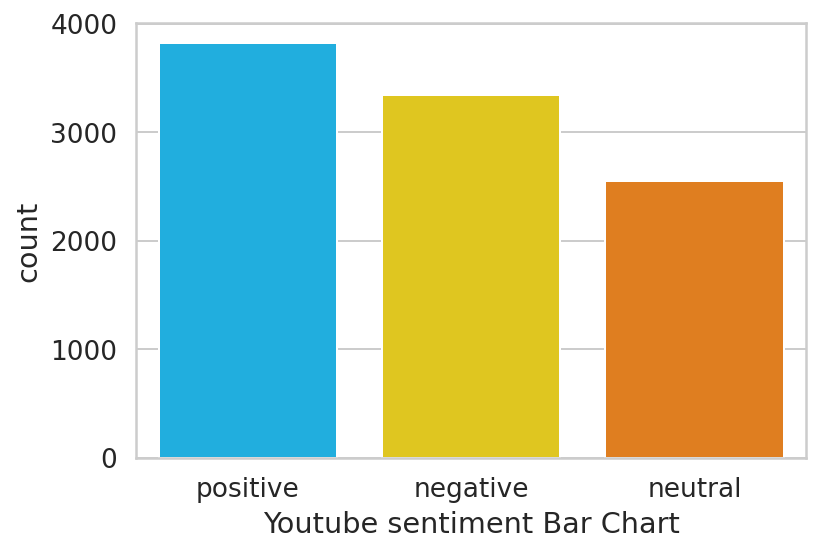

In [3]:
# View the amount of data for each sentiment on the dataset
class_names = ['positive', 'negative', 'neutral']

ax = sns.countplot(df_yt_comment.polarity)
plt.xlabel('Youtube sentiment Bar Chart')
ax.set_xticklabels(class_names);

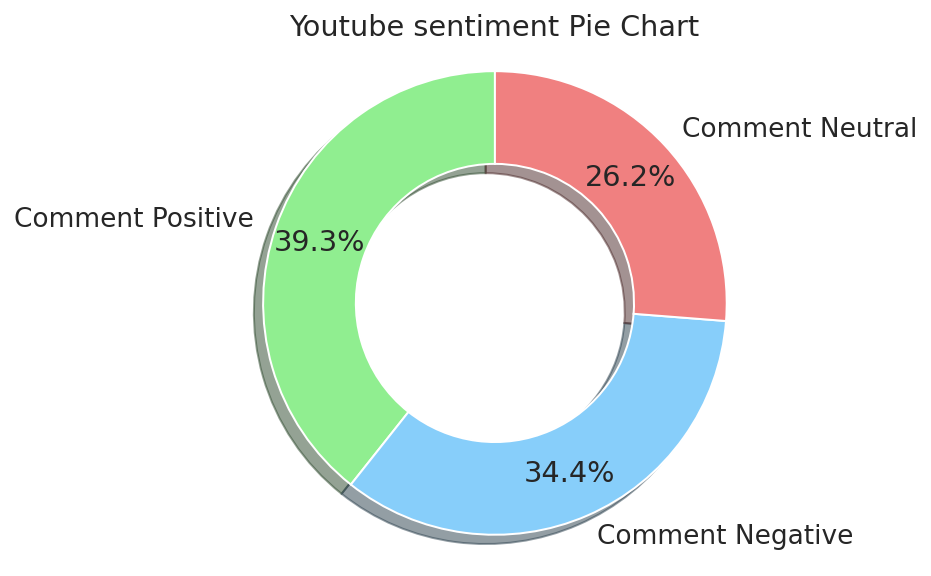

In [4]:
# Function to make a donut chart
def donut(sizes, ax, angle=90, labels=None,colors=None, explode=None, shadow=None):

    # Plot
    ax.pie(sizes, colors = colors, labels=labels, autopct='%.1f%%', 
           startangle = angle, pctdistance=0.8, explode = explode, 
           wedgeprops=dict(width=0.4), shadow=shadow)

    # Formatting
    plt.axis('equal')  
    plt.tight_layout()


# Plot arguments
sizes = df_yt_comment.polarity.value_counts()
labels = ['Comment Positive', 'Comment Negative', 'Comment Neutral']
colors = ['lightgreen', 'lightskyblue', 'lightcoral']
explode = (0,0,0)

# Create axes
f, ax = plt.subplots(figsize=(6,4))
# plot donut
donut(sizes, ax, 90, labels, colors=colors, explode=explode, shadow=True)
ax.set_title('Youtube sentiment Pie Chart')
plt.show()

In [5]:
# Just column text_clean and sentiment that will used
df_sentiment_bert = df_yt_comment[['text_clean', 'sentiment']]
df_sentiment_bert

,text_clean,sentiment
0,pakai behel gigi rapi tidak pada senyum tertaw...,1
1,warna karet behel bagus kakak,1
2,habis lepas behel k pakai retainer gigi tidak ...,0
3,gigi masuk rapi tipe open bite gigi tidak sali...,1
4,ngerapihin gigi pergi kah gigi langsung padang,1
...,...,...
9701,mb kemarin pergi gigi rumah sakit daerah pakai...,0
9702,gigi juta kak gigi beli motor kak,1
9703,sat jakbar nama liem clinic cari klinik saran ...,1
9704,sp ort maksud kak pasang kawat gigi ahli gigi ...,1


# **Step #8 Prepare For BERT Sentiment Analysis**

<img src="https://miro.medium.com/max/1032/0*x3vhaoJdGndvZqmL.png" height=400 width=500>
<br>
<br>

BERT is a state-of-the-art method of building language models that uses a deep learning approach. BERT uses transformers which are an attention mechanism that studies contextual relationships between words in a text. Broadly speaking, transformers consist of two separate mechanisms, namely an encoder that functions to read the input text and a decoder that produces predictions for certain jobs. Since the goal of BERT is to produce a language model, only the encoder mechanism is considered important.

BERT is very instrumental in one of the subtopics of Artificial Intelligence Natural Language Processing, namely Natural Language Understanding (NLU). NLU works by interpreting a meaning from human language and classifying it into machine-understood intents. There are many kinds of work in NLU that can be completed by BERT, including Question Answering (QA), sentiment analysis, machine translation, Named Entity Recognition (NER), and others.

<br>

**Required Formatting**

We are required to:

1.   Add special tokens at the beginning and end of each sentence
2.   Pad or truncated all sentences to a certain length
3.   Prepare "attention mask"

<br>

**Special Tokens**

**[SEP]**

At the end of each sentence, we need to add [SEP] token.

**[CLS]**

For classification tasks, we must add [CLS] token to the beginning of each sentence.

<img src="http://www.mccormickml.com/assets/BERT/CLS_token_500x606.png" height=400 width=400>

On the output of the final (12th) transformer, only the first embedding (corresponding to the [CLS] token) is used by the classifier.

> "The first token of every sequence is always a special classification token ([CLS]). The final hidden state corresponding to this token is used as the aggregate sequence representation for classification tasks." (from the BERT paper)

<br>

**Sentence Length & Attention Mask**

Sentence length in the dataset varies greatly, so how does BERT handle this?

BERT punya 2 batasan :

1.   All sentences must be padded or truncate into one fixed length
2.   Max sentence length is 512 tokens

<br>

**Padding use special token**

**[PAD]**

<img src="http://www.mccormickml.com/assets/BERT/padding_and_mask.png" height=400 width=500>

"Attention Mask" is an array consisting of '1' and '0' where '1' indicates the token is padding and '0' which is not. This mask tells BERT's "Self-Attention" not to include this **[PAD]** token when interpreting sentences.


# **8.1 Tokenize Dataset**

In [6]:
# Dict mapping
label2num = {'negative': 0, 'positive': 1, 'neutral':2}
num2label = {0: 'negative', 1: 'positive', 2: 'neutral'}

In [7]:
print('Loading BERT tokenizer...')
# Load BertTokenizer
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1', do_lower_case=True)

Loading BERT tokenizer...


In [8]:
# Training data only use 4000 sentence
sentences = df_sentiment_bert.text_clean.values[:4000]
labels = df_sentiment_bert.sentiment.values[:4000]

# Testing data only use 1000 sentence
test_sentences = df_sentiment_bert.text_clean.values[:1000]
test_labels = df_sentiment_bert.sentiment.values[:1000]

sent_length = []

# For every sentence...
for sent in sentences:
    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)
    sent_length.append(len(input_ids))

print('Average length = ', sum(sent_length)/len(sent_length))
print('Median length = ', statistics.median(sent_length))

Average length =  11.33
Median length =  8.0


Max length set into 256.

The tokenizer.encode_plus function performs several steps:

1. Split sentences into tokens
2. Add special token ([CLS] and [SEP])
3. Mapping token into ID
4. Pad or truncate all sentence into same length
5. Make attention mask

In [9]:
# Tokenize all of the sentences and map the tokens to their word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    encoded_dict = tokenizer.encode_plus(
                        sent,                        # Sentence to encode.
                        add_special_tokens = True,   # Add '[CLS]' and '[SEP]'
                        max_length = 256,            # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,# Construct attn. masks.
                        return_tensors = 'pt',       # Return pytorch tensors.
                        truncation = True
                   )
    
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Original:  pakai behel gigi rapi tidak pada senyum tertawa gigi rengang rahang maju malu kadang minimal usia pakai behel usia
Token IDs: tensor([    2,  2468, 26238,  3168,  6767,   119,   126,  7319,  7519,  3168,
        23431,    16, 18819,  3649,  5535,  3597,  3311,  1816,  2468, 26238,
         1816,     3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
     

# **Step #9 Splitting Dataset Become Training, Validation, Testing**



In [10]:
# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 80-20 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

3,200 training samples
  800 validation samples


We'll also create an iterator for our dataset using the torch DataLoader class. This helps save on memory during training because, unlike a for loop, with an iterator the entire dataset does not need to be loaded into memory.

In [11]:
# For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            num_workers=16,
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            num_workers=16,
            batch_size = batch_size # Evaluate with this batch size.
        )

# **8.2. BertForSequenceClassification**

We'll be using BertForSequenceClassification. This is the normal BERT model with an added single linear layer on top for classification that we will use as a sentence classifier. As we feed input data, the entire pre-trained BERT model and the additional untrained classification layer is trained on our specific task.

In [12]:
# Load BertForSequenceClassification, the pretrained BERT model with a single 
# Linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    'indobenchmark/indobert-base-p1', # Use the 12-layer BERT model, with an cased vocab.
    num_labels = 3, 
    output_attentions = False, # Return attentions weights
    output_hidden_states = False, # Returns all hidden-states
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [13]:
# Structure model
# Get all model parameters in a list of tuples
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (50000, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

# **8.3. Optimizer & Learning Rate Scheduler**

For fine-tuning, the authors recommend choosing from the following values (from Appendix A.3 of the BERT paper):


> *   Batch size: 16, 32
*   Learning rate (Adam): 5e-5, 3e-5, 2e-5
*   Number of epochs: 2, 3, 4


We chose:

*    Batch size: 32 (set when creating our DataLoaders)
*    Learning rate: 2e-5
*    Epochs: 3

The epsilon parameter eps = 1e-8 is "a very small number to prevent any division by zero in the implementation.

**get_linear_schedule_with_warmup** function : Create a schedule with a learning rate that decreases linearly after linearly increasing during a warmup period.

In [14]:
# Set Optimizer
optimizer = AdamW(model.parameters(),lr = 2e-5, eps = 1e-8)
# Set Epochs
epochs = 10

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
print('Jumlah batch :', len(train_dataloader))
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

Jumlah batch : 100


In [15]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

# **Step #10 Training and Validation Model BERT**

Training :

*   Unpack our data inputs and labels
*   Load data to GPU
*   Clear out the gradients calculated in the previous pass
*   Forward pass (feed input data through the network)
*   Backward pass (backpropagation)
*   Tell the network to update parameters with optimizer.step()
*   Track variables for monitoring progress

Evaluation :

*   Unpack our data inputs and labels
*   Load data to GPU
*   Forward pass (feed input data through the network)
*   Compute loss on our validation data and track variables for monitoring progress

In [19]:
# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# List variable for store training and validation loss, validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):
        # Progress update every 20 batches.
        if step % 20 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a backward pass
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # token_type_ids is same as the "segment ids", which differentiates 
        # sentence 1 and 2 in sentence-pair tasks
        outputs = model(b_input_ids, 
                      token_type_ids=None,
                      attention_mask=b_input_mask, 
                      labels=b_labels)
        
        loss = outputs[0]
        logits = outputs[1]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. 
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
    
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode (batchnorm, dropout disable)
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Deactivate autograd, it will reduce memory usage and speed up computations
        # but you won’t be able to backprop (which you don’t want in an eval script).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask,
                            labels=b_labels)
            
            loss = outputs[0]
            logits = outputs[1]
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)

     # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'Epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Validation Loss': avg_val_loss,
            'Validation Accuracy': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 10 ========
Training...
  Batch    20  of    100.    Elapsed: 0:00:27.
  Batch    40  of    100.    Elapsed: 0:00:53.
  Batch    60  of    100.    Elapsed: 0:01:21.
  Batch    80  of    100.    Elapsed: 0:01:48.

  Average training loss: 0.34
  Training epoch took: 0:02:15

Running Validation...
  Accuracy: 0.86
  Validation Loss: 0.39
  Validation took: 0:00:15

======== Epoch 2 / 10 ========
Training...
  Batch    20  of    100.    Elapsed: 0:00:28.
  Batch    40  of    100.    Elapsed: 0:00:55.
  Batch    60  of    100.    Elapsed: 0:01:22.
  Batch    80  of    100.    Elapsed: 0:01:49.

  Average training loss: 0.20
  Training epoch took: 0:02:16

Running Validation...
  Accuracy: 0.86
  Validation Loss: 0.40
  Validation took: 0:00:14

======== Epoch 3 / 10 ========
Training...
  Batch    20  of    100.    Elapsed: 0:00:28.
  Batch    40  of    100.    Elapsed: 0:00:55.
  Batch    60  of    100.    Elapsed: 0:01:22.
  Batch    80  of    100.    Elapsed: 0:01:49

In [20]:
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('Epoch')

# Display the table.
df_stats

,Training Loss,Validation Loss,Validation Accuracy,Training Time,Validation Time
Epoch,,,,,
1,3.35e-01,0.39,0.86,0:02:15,0:00:15
2,1.95e-01,0.40,0.86,0:02:16,0:00:14
3,1.22e-01,0.46,0.88,0:02:16,0:00:15
4,8.09e-02,0.57,0.87,0:02:16,0:00:14
5,4.84e-02,0.61,0.87,0:02:16,0:00:14
6,3.17e-02,0.62,0.87,0:02:16,0:00:14
7,1.75e-02,0.65,0.88,0:02:16,0:00:14
8,1.16e-02,0.67,0.87,0:02:16,0:00:14
9,3.61e-03,0.68,0.88,0:02:15,0:00:14


(0.0, 1.0)

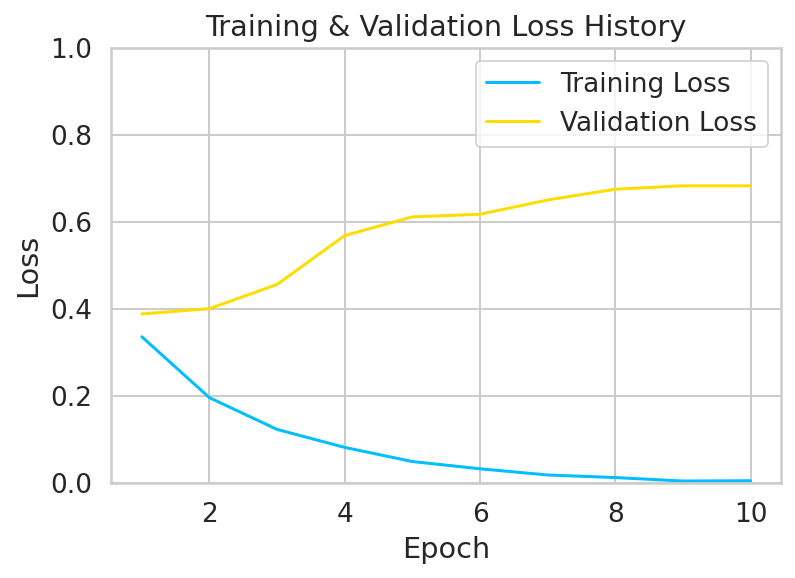

In [21]:
# Evaluation of training and validation loss
plt.figure(figsize=(6,4))
plt.plot(df_stats['Training Loss'], label='Training Loss')
plt.plot(df_stats['Validation Loss'], label='Validation Loss')
plt.title('Training & Validation Loss History')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])

# **Step #10 Evaluation Model Bert and Prediction New Data**

With the test set prepared, we can apply our fine-tuned model to generate predictions on the test set.

In [22]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in test_sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 256,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                        truncation = True
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(test_labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [23]:
# Prediction on test set
print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('DONE.')

Predicting labels for 1,000 test sentences...
DONE.


In [24]:
# flatten prediction and true lists
flat_pred = []
flat_true = []
for i in range(len(predictions)):
    for j in range(len(predictions[i])):
        flat_pred.append(predictions[i][j])
        flat_true.append(true_labels[i][j])
        
print(f"Number of testing samples results: {len(flat_pred)}")

Number of testing samples results: 1000


In [25]:
# Calculate accuracy for test dataset
total_accuracy = 0

for batch_num in range(len(predictions)): 
  total_accuracy += flat_accuracy(predictions[batch_num], true_labels[batch_num])

total_accuracy = total_accuracy/len(predictions)*100
print('Accuracy on test dataset:', total_accuracy)

print('\n')
# Classification report
class_names = ['Negative', 'Positive', 'Neutral']
print(classification_report(flat_true, np.argmax(flat_pred, axis=1), digits=4, target_names=class_names))

Accuracy on test dataset: 97.8515625


              precision    recall  f1-score   support

    Negative     0.9659    0.9808    0.9733       260
    Positive     0.9853    0.9833    0.9843       478
     Neutral     0.9768    0.9656    0.9712       262

    accuracy                         0.9780      1000
   macro avg     0.9760    0.9766    0.9763      1000
weighted avg     0.9781    0.9780    0.9780      1000



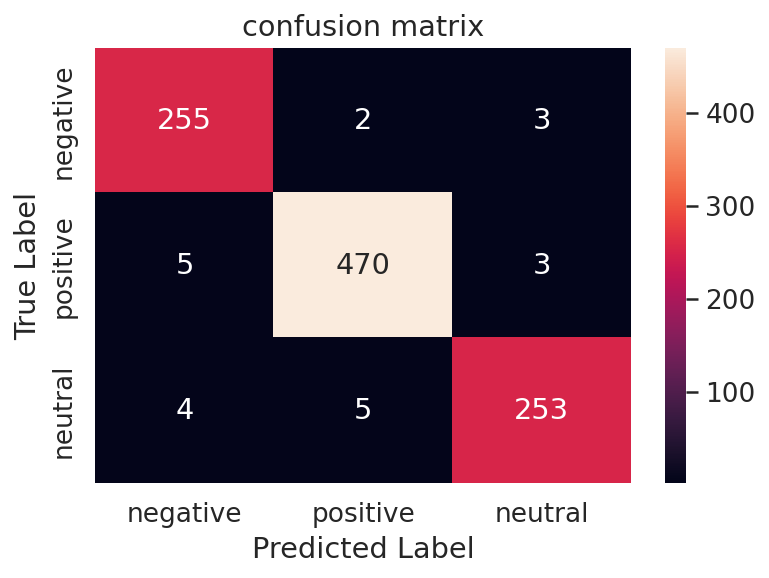

In [26]:
# Plot confusion matrix
confusion_matrix_df = pd.DataFrame(confusion_matrix(flat_true, np.argmax(flat_pred, axis=1))).rename(columns=num2label, index=num2label)
sns.heatmap(confusion_matrix_df, annot=True, fmt='').set(title="confusion matrix", xlabel="Predicted Label", ylabel="True Label")
plt.show()

# **Saving Model**

In [27]:
# Save tokenizer
tokenizer.save_pretrained('SA01-INDO-BERT-MODEL/')

('SA01-INDO-BERT-MODEL/tokenizer_config.json',
 'SA01-INDO-BERT-MODEL/special_tokens_map.json',
 'SA01-INDO-BERT-MODEL/vocab.txt',
 'SA01-INDO-BERT-MODEL/added_tokens.json')

In [28]:
# Save model Bert
model.save_pretrained('SA01-INDO-BERT-MODEL/')

# **Prediction With New Text**

In [29]:
text = "Aku baru sebulan udah pengen lepas rasanya. Udah gak peduli uang yang keluar sayang. Pokoknya gak nyaman, setiap hari sedih terus. Akhirnya aku cerita ke dokterku kalau aku dah gak kuat aku bilang kalau bakal bertahan 2 atau 3 bulan dari pemasangan behel. Setelah itu aku minta buat beneran lepas aja. Pokoknya jangan ragu buat cerita ke dokter"
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]

label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {num2label[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: Aku baru sebulan udah pengen lepas rasanya. Udah gak peduli uang yang keluar sayang. Pokoknya gak nyaman, setiap hari sedih terus. Akhirnya aku cerita ke dokterku kalau aku dah gak kuat aku bilang kalau bakal bertahan 2 atau 3 bulan dari pemasangan behel. Setelah itu aku minta buat beneran lepas aja. Pokoknya jangan ragu buat cerita ke dokter | Label : negative (99.147%)


In [30]:
text = "Kak, pas awal pasang bracketnya suka lepas nggak? Apa cuman punyaku doang yang suka lepas dbagian ujung2nya"
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {num2label[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: Kak, pas awal pasang bracketnya suka lepas nggak? Apa cuman punyaku doang yang suka lepas dbagian ujung2nya | Label : positive (94.052%)


# **Push Model To Huggingface For Transformer**

In [ ]:
!huggingface-cli login

In [32]:
from huggingface_hub import HfApi, HfFolder
import os

api = HfApi()
folder = HfFolder()
token = folder.get_token()

api.create_repo(token, "SA01-IndoBert")

'https://huggingface.co/liandarizkia/SA01-IndoBert'

In [33]:
api.upload_file(token=token, repo_id="liandarizkia/SA01-IndoBert", path_or_fileobj="SA01-INDO-BERT-MODEL/pytorch_model.bin", path_in_repo="pytorch_model.bin")

'https://huggingface.co/liandarizkia/SA01-IndoBert/blob/main/pytorch_model.bin'